### Python Code version 1 from link: https://thepythoncode.com/article/speech-recognition-using-huggingface-transformers-in-python
* Steps:
1. Automatic Speech Recognition (ASR) is the technology that allows us to convert human speech into digital text. This tutorial will dive into using the Huggingface Transformers library in Python to perform speech recognition using two of the most-known and state-of-the-art models, which are Wav2Vec 2.0 and Whisper.
2. **`Wav2Vec2`** is a pre-trained model that was trained on speech audio alone (self-supervised) and then followed by fine-tuning on transcribed speech data (LibriSpeech dataset). It has outperformed previous semi-supervised models.
3. **`Whisper`**, on the other hand, is a general-purpose speech recognition transformer model, trained on a large dataset of diverse weakly supervised audio (680,000 hours) on multiple languages and also multiple tasks (speech recognition, speech translation, language identification, and voice activity detection).

Tutorial:
- Getting Started
- Using Wav2Vec 2.0 Models
  - Loading the Model
  - Preparing the Audio File
  - Performing Inference
  - Wrapping up the Code
- Using Whisper Models
  - Loading the Model
  - Preparing the Audio File
  - Performing Inference
  - Wrapping up the Code
- Transcribing your Voice
- Transcribing Long Audio Samples
- Conclusion

We'll be using torchaudio for loading audio files. Note that you need to install PyAudio if you're going to use the code on your environment and PyDub if you're on a Colab environment. We are going to use them for recording from the microphone in Python.

Using Whisper Models
The cool thing about Whisper is that there is a single model for almost all the world languages, and you only have to specify the language by prepending the decoding with special language tokens.

The below tables show the different Whisper models, their number of parameters, size, and links to multilingual and English-only models:

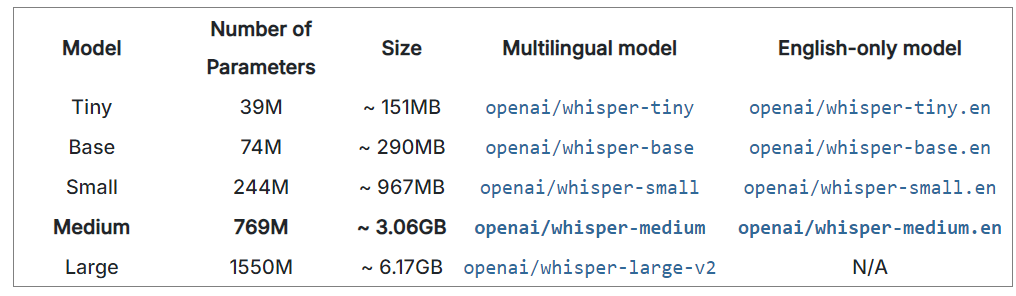

Loading the Model
Let's load the openai/whisper-medium one:

In [1]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration

c:\Users\PC\Documents\Speech2Text\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import soundfile as sf
import librosa
import os
import torchaudio

device = "cuda" if torch.cuda.is_available() else "cpu"
device

ModuleNotFoundError: No module named 'librosa'

In [4]:
device="cuda"

In [5]:
# whisper_model_name = "openai/whisper-tiny.en" # English-only, ~ 151 MB
# whisper_model_name = "openai/whisper-base.en" # English-only, ~ 290 MB
# whisper_model_name = "openai/whisper-small.en" # English-only, ~ 967 MB
# whisper_model_name = "openai/whisper-medium.en" # English-only, ~ 3.06 GB
whisper_model_name = "openai/whisper-tiny" # multilingual, ~ 151 MB
# whisper_model_name = "openai/whisper-base" # multilingual, ~ 290 MB
# whisper_model_name = "openai/whisper-small" # multilingual, ~ 967 MB
# whisper_model_name = "openai/whisper-medium" # multilingual, ~ 3.06 GB
# whisper_model_name = "openai/whisper-large-v2" # multilingual, ~ 6.17 GB
# load the whisper model and tokenizer
whisper_processor = WhisperProcessor.from_pretrained(whisper_model_name)
whisper_model = WhisperForConditionalGeneration.from_pretrained(whisper_model_name).to(device)

In [9]:
vocab = whisper_processor.tokenizer.get_vocab()
# Print the first 10 tokens
for token, index in list(vocab.items()):
    print(f"Token: {token}, Index: {index}")

Token: !, Index: 0
Token: ", Index: 1
Token: #, Index: 2
Token: $, Index: 3
Token: %, Index: 4
Token: &, Index: 5
Token: ', Index: 6
Token: (, Index: 7
Token: ), Index: 8
Token: *, Index: 9
Token: +, Index: 10
Token: ,, Index: 11
Token: -, Index: 12
Token: ., Index: 13
Token: /, Index: 14
Token: 0, Index: 15
Token: 1, Index: 16
Token: 2, Index: 17
Token: 3, Index: 18
Token: 4, Index: 19
Token: 5, Index: 20
Token: 6, Index: 21
Token: 7, Index: 22
Token: 8, Index: 23
Token: 9, Index: 24
Token: :, Index: 25
Token: ;, Index: 26
Token: <, Index: 27
Token: =, Index: 28
Token: >, Index: 29
Token: ?, Index: 30
Token: @, Index: 31
Token: A, Index: 32
Token: B, Index: 33
Token: C, Index: 34
Token: D, Index: 35
Token: E, Index: 36
Token: F, Index: 37
Token: G, Index: 38
Token: H, Index: 39
Token: I, Index: 40
Token: J, Index: 41
Token: K, Index: 42
Token: L, Index: 43
Token: M, Index: 44
Token: N, Index: 45
Token: O, Index: 46
Token: P, Index: 47
Token: Q, Index: 48
Token: R, Index: 49
Token: S, 

We use the WhisperProcessor to process our audio file, and WhisperForConditionalGeneration for loading the model.

If get an out-of-memory error, you're free to use a smaller Whisper model, such as openai/whisper-tiny.

Preparing the Audio File
Let's use the same audio_url defined earlier. First, extracting the audio features:

In [7]:
# Gettign the audio file
# audio_url = "https://github.com/x4nth055/pythoncode-tutorials/raw/master/machine-learning/speech-recognition/16-122828-0002.wav"
audio_url = "https://github.com/x4nth055/pythoncode-tutorials/raw/master/machine-learning/speech-recognition/30-4447-0004.wav"
# audio_url = "https://github.com/x4nth055/pythoncode-tutorials/raw/master/machine-learning/speech-recognition/7601-291468-0006.wav"

In [8]:
def load_audio(audio_path):
  """Load the audio file & convert to 16,000 sampling rate"""
  # load our wav file
  speech, sr = torchaudio.load(audio_path)
  resampler = torchaudio.transforms.Resample(sr, 16000)
  speech = resampler(speech)
  return speech.squeeze()

In [9]:
# get the input features
input_features = whisper_processor(load_audio("t1.mp3"), sampling_rate=16000, return_tensors="pt").input_features.to(device)
input_features.shape

torch.Size([1, 80, 3000])

Very Good website t understand more in details: https://github.com/openai/whisper

We set the language to "english" and the task to "transcribe" for English speech recognition. Here's the output:

In [10]:
# get special decoder tokens for the language
forced_decoder_ids = whisper_processor.get_decoder_prompt_ids(language="english", task="transcribe")
forced_decoder_ids

[(1, 50259), (2, 50359), (3, 50363)]

In [11]:
# perform inference
predicted_ids = whisper_model.generate(input_features, forced_decoder_ids=forced_decoder_ids)
predicted_ids.shape

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
c:\Users\anupa\OneDrive\Desktop\Eneru_Projects\myenv\Lib\site-packages\transformers\models\whisper\modeling_whisper.py:598: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


torch.Size([1, 35])

In [12]:
# decode the IDs to text
transcription = whisper_processor.batch_decode(predicted_ids, skip_special_tokens=True)
transcription

[' Perhaps he made up to the party afterwards and took her and his heart at end continued. It was not theorized, set it over her. Edmund']

Wrapping up the Code
Let's now wrap everything into a single function, as previously:

In [15]:
# %%writefile going_modular/whisper_result.py
# import torchaudio
# import torch

def load_audio(audio_path):
  """Load the audio file & convert to 16,000 sampling rate"""
  # load our wav file
  speech, sr = torchaudio.load(audio_path)
  resampler = torchaudio.transforms.Resample(sr, 16000)
  speech = resampler(speech)
  return speech.squeeze()

def get_transcription_whisper(audio_path, model, processor, language="english", skip_special_tokens=True):
  # resample from whatever the audio sampling rate to 16000
  speech = load_audio(audio_path)
  # get the input features
  input_features = processor(speech, return_tensors="pt", sampling_rate=16000).input_features.to(device)
  # get special decoder tokens for the language
  forced_decoder_ids = processor.get_decoder_prompt_ids(language=language, task="transcribe")
  # perform inference
  predicted_ids = model.generate(input_features, forced_decoder_ids=forced_decoder_ids)
  # decode the IDs to text
  transcription = processor.batch_decode(predicted_ids, skip_special_tokens=skip_special_tokens)[0]
  return transcription

Writing going_modular/whisper_result.py


In [ ]:
get_transcription_whisper("t2_m.m4a", whisper_model, whisper_processor,
                          language="marathi")

In [17]:
get_transcription_whisper("t1.mp3", whisper_model, whisper_processor,
                          language="english")

' Perhaps he made up to the party afterwards and took her and his heart at end continued. It was not theorized, set it over her. Edmund'

In [18]:
from transformers.models.whisper.tokenization_whisper import TO_LANGUAGE_CODE
# supported languages
TO_LANGUAGE_CODE

{'english': 'en',
 'chinese': 'zh',
 'german': 'de',
 'spanish': 'es',
 'russian': 'ru',
 'korean': 'ko',
 'french': 'fr',
 'japanese': 'ja',
 'portuguese': 'pt',
 'turkish': 'tr',
 'polish': 'pl',
 'catalan': 'ca',
 'dutch': 'nl',
 'arabic': 'ar',
 'swedish': 'sv',
 'italian': 'it',
 'indonesian': 'id',
 'hindi': 'hi',
 'finnish': 'fi',
 'vietnamese': 'vi',
 'hebrew': 'he',
 'ukrainian': 'uk',
 'greek': 'el',
 'malay': 'ms',
 'czech': 'cs',
 'romanian': 'ro',
 'danish': 'da',
 'hungarian': 'hu',
 'tamil': 'ta',
 'norwegian': 'no',
 'thai': 'th',
 'urdu': 'ur',
 'croatian': 'hr',
 'bulgarian': 'bg',
 'lithuanian': 'lt',
 'latin': 'la',
 'maori': 'mi',
 'malayalam': 'ml',
 'welsh': 'cy',
 'slovak': 'sk',
 'telugu': 'te',
 'persian': 'fa',
 'latvian': 'lv',
 'bengali': 'bn',
 'serbian': 'sr',
 'azerbaijani': 'az',
 'slovenian': 'sl',
 'kannada': 'kn',
 'estonian': 'et',
 'macedonian': 'mk',
 'breton': 'br',
 'basque': 'eu',
 'icelandic': 'is',
 'armenian': 'hy',
 'nepali': 'ne',
 'mongol

### Transcribing your Voice
if you want to use your voice, I have prepared a code snippet at the end of the notebooks to record with your microphone. First, cloning the repo:

In [30]:
!git clone -q --depth 1 https://github.com/snakers4/silero-models

%cd silero-models

/content/silero-models


### How to record audio real time

In [34]:
from IPython.display import Audio, display, clear_output
from colab_utils import record_audio
import ipywidgets as widgets
from scipy.io import wavfile
import numpy as np

record_seconds =   25#@param {type:"number", min:1, max:10, step:1}
sample_rate = 16000

def _record_audio(b):
  clear_output()
  audio = record_audio(record_seconds)
  display(Audio(audio, rate=sample_rate, autoplay=True))
  wavfile.write('recorded.wav', sample_rate, (32767*audio).numpy().astype(np.int16))

button = widgets.Button(description="Record Speech")
button.on_click(_record_audio)
display(button)

Starting recording for 25 seconds...


<IPython.core.display.Javascript object>

Finished recording!


In [35]:
print("Whisper:", get_transcription_whisper("recorded.wav", whisper_model, whisper_processor))
#print("Wav2vec2:", get_transcription_wav2vec2("recorded.wav", wav2vec2_model, wav2vec2_processor))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (448) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Whisper:  Suppose you want to translate text from one language to another. Most people's first point of call is an online translation service from one of the big cloud providers and most translation libraries in Python wrap Google Translate. However, the free service have rate limits. The paid


Suppose you want to translate text from one language to another. Most people's first point of call is an online translation service from one of the big cloud providers and most translation libraries in Python wrap Google Translate. However, the free service have rate limits. The paid

### Transcribing Long Audio Samples

Lets make the code more granular, to give an understandign of the language spoken, identitfy the language spoken
Link to them are here :
1. https://github.com/openai/whisper/discussions/categories/show-and-tell
2. https://github.com/davabase/whisper_real_time
3. https://github.com/davabase/transcriber_app/
4. https://skeptric.com/python-offline-translation/
5. https://github.com/chidiwilliams/buzz
6. https://github.com/usefulsensors/openai-whisper/blob/main/android_app/release/app-release.apk

List of languages available for whisper : https://github.com/openai/whisper/blob/main/whisper/tokenizer.py

For indian speech differetn model: https://github.com/snakers4/silero-models

In [20]:
import whisper
model = whisper.load_model("base")
result = model.transcribe("t1.mp3")
print(result["text"])

100%|███████████████████████████████████████| 139M/139M [00:13<00:00, 10.9MiB/s]
c:\Users\anupa\OneDrive\Desktop\Eneru_Projects\myenv\Lib\site-packages\whisper\__init__.py:146: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for a

FileNotFoundError: [WinError 2] The system cannot find the file specified

Internally, the transcribe() method reads the entire file and processes the audio with a sliding 30-second window, performing autoregressive sequence-to-sequence predictions on each window.

Below is an example usage of whisper.detect_language() and whisper.decode() which provide lower-level access to the model.

In [21]:
import whisper

model = whisper.load_model("base")

# load audio and pad/trim it to fit 30 seconds
audio = whisper.load_audio("t1.mp3")
audio = whisper.pad_or_trim(audio)

# make log-Mel spectrogram and move to the same device as the model
mel = whisper.log_mel_spectrogram(audio).to(model.device)

# detect the spoken language
_, probs = model.detect_language(mel)
print(f"Detected language: {max(probs, key=probs.get)}")

# decode the audio
options = whisper.DecodingOptions()
result = whisper.decode(model, mel, options)

# print the recognized text
print(result.text)

FileNotFoundError: [WinError 2] The system cannot find the file specified

### This is the real time Whisper transcribing


In [22]:
%%writefile real_time.py
#! python3.7

import argparse
import os
import numpy as np
import speech_recognition as sr
import whisper
import torch

from datetime import datetime, timedelta
from queue import Queue
from time import sleep
from sys import platform


def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--model", default="medium", help="Model to use",
                        choices=["tiny", "base", "small", "medium", "large"])
    parser.add_argument("--non_english", action='store_true',
                        help="Don't use the english model.")
    parser.add_argument("--energy_threshold", default=1000,
                        help="Energy level for mic to detect.", type=int)
    parser.add_argument("--record_timeout", default=2,
                        help="How real time the recording is in seconds.", type=float)
    parser.add_argument("--phrase_timeout", default=3,
                        help="How much empty space between recordings before we "
                             "consider it a new line in the transcription.", type=float)
    if 'linux' in platform:
        parser.add_argument("--default_microphone", default='Realtek High Definition Audio',
                            help="Default microphone name for SpeechRecognition. "
                                 "Run this with 'list' to view available Microphones.", type=str)
    args = parser.parse_args()

    # The last time a recording was retrieved from the queue.
    phrase_time = None
    # Thread safe Queue for passing data from the threaded recording callback.
    data_queue = Queue()
    # We use SpeechRecognizer to record our audio because it has a nice feature where it can detect when speech ends.
    recorder = sr.Recognizer()
    recorder.energy_threshold = args.energy_threshold
    # Definitely do this, dynamic energy compensation lowers the energy threshold dramatically to a point where the SpeechRecognizer never stops recording.
    recorder.dynamic_energy_threshold = False

    source=None
    # Important for linux users.
    # Prevents permanent application hang and crash by using the wrong Microphone
    if 'linux' in platform:
        mic_name = args.default_microphone
        if not mic_name or mic_name == 'list':
            print("Available microphone devices are: ")
            for index, name in enumerate(sr.Microphone.list_microphone_names()):
                print(f"Microphone with name \"{name}\" found")
            return
        else:
            for index, name in enumerate(sr.Microphone.list_microphone_names()):
                if mic_name in name:
                    source = sr.Microphone(sample_rate=16000, device_index=index)
                    break
            if source is None:
              print(f"Microphone with name '{mic_name}' not found.")
              return
    else:
        source = sr.Microphone(sample_rate=16000)

    # Load / Download model
    model = args.model
    if args.model != "large" and not args.non_english:
        model = model + ".en"
    audio_model = whisper.load_model(model)

    record_timeout = args.record_timeout
    phrase_timeout = args.phrase_timeout

    transcription = ['']

    # with source:
    recorder.adjust_for_ambient_noise(source)

    def record_callback(_, audio:sr.AudioData) -> None:
        """
        Threaded callback function to receive audio data when recordings finish.
        audio: An AudioData containing the recorded bytes.
        """
        # Grab the raw bytes and push it into the thread safe queue.
        data = audio.get_raw_data()
        data_queue.put(data)

    # Create a background thread that will pass us raw audio bytes.
    # We could do this manually but SpeechRecognizer provides a nice helper.
    recorder.listen_in_background(source, record_callback, phrase_time_limit=record_timeout)

    # Cue the user that we're ready to go.
    print("Model loaded.\n")

    while True:
        try:
            now = datetime.utcnow()
            # Pull raw recorded audio from the queue.
            if not data_queue.empty():
                phrase_complete = False
                # If enough time has passed between recordings, consider the phrase complete.
                # Clear the current working audio buffer to start over with the new data.
                if phrase_time and now - phrase_time > timedelta(seconds=phrase_timeout):
                    phrase_complete = True
                # This is the last time we received new audio data from the queue.
                phrase_time = now

                # Combine audio data from queue
                audio_data = b''.join(data_queue.queue)
                data_queue.queue.clear()

                # Convert in-ram buffer to something the model can use directly without needing a temp file.
                # Convert data from 16 bit wide integers to floating point with a width of 32 bits.
                # Clamp the audio stream frequency to a PCM wavelength compatible default of 32768hz max.
                audio_np = np.frombuffer(audio_data, dtype=np.int16).astype(np.float32) / 32768.0

                # Read the transcription.
                result = audio_model.transcribe(audio_np, fp16=torch.cuda.is_available())
                text = result['text'].strip()

                # If we detected a pause between recordings, add a new item to our transcription.
                # Otherwise edit the existing one.
                if phrase_complete:
                    transcription.append(text)
                else:
                    transcription[-1] = text

                # Clear the console to reprint the updated transcription.
                os.system('cls' if os.name=='nt' else 'clear')
                for line in transcription:
                    print(line)
                # Flush stdout.
                print('', end='', flush=True)
            else:
                # Infinite loops are bad for processors, must sleep.
                sleep(0.25)
        except KeyboardInterrupt:
            break

    print("\n\nTranscription:")
    for line in transcription:
        print(line)


if __name__ == "__main__":
    main()

Overwriting real_time.py


In [26]:
import sys
sys.argv = ['real_time.py']


In [27]:
from easydict import EasyDict
args = EasyDict({
    "model": "medium",
    "non_english": False,
    "energy_threshold": 1000,
    "record_timeout": 2,
    "phrase_timeout": 3
})


In [1]:
!python real_time.py --model base --default_microphone list


python3: can't open file '/content/real_time.py': [Errno 2] No such file or directory
